<a href="https://colab.research.google.com/github/d-vf/notebooks/blob/master/VC_and_Public_Funds_Probit_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

* R kernel (https://github.com/IRkernel/IRkernel)

In [1]:
cat(system('python3 -c "from google.colab import drive\ndrive.mount()"', intern=TRUE), sep='\n', wait=TRUE)

Warning message in system("python3 -c \"from google.colab import drive\ndrive.mount()\"", :
“running command 'python3 -c "from google.colab import drive
drive.mount()"' had status 1”



TRUE


In [2]:
system("add-apt-repository -y ppa:marutter/rrutter")
system("add-apt-repository -y ppa:marutter/c2d4u")
system("apt-get update")
system("apt install -y r-cran-rstan")
system('apt-get install libv8-dev') #FOR v8

## Libraries

In [3]:
install.packages('codetools') #Code Analysis Tools for R
install.packages("devtools")
install.packages('data.table') #Fast aggregation of large data (not needed as 20 0000 is a small sample)

install.packages('ggplot2') #for basic charts this is not needed (as has a learning curve)
install.packages('stargazer') #beautiful LATEX, HTML and ASCII tables from R statistical output (not needed as the output is not latex and be used UTF-8)

install.packages('lmtest') #Testing Linear Regression Models

install.packages('dplyr') # A Grammar of Data Manipulation (to replace data.table)

install.packages('mfx') #for marginal effects

#For TMLE
install.packages('tmle')
install.packages('dbarts')
install.packages('gam')

# CPA/Corr
install.packages("factoextra")
install.packages("farver")
install.packages('GGally') # corr plot and confusion matrix

#ROC
install.packages('InformationValue')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Inst

## Data

In [67]:
library(readr)
url <- "/content/Final_table_3.csv"
Finaltable <- read.csv(url, header=TRUE, quote="\"", na.strings = "NA", fill = TRUE )

## Data Treatment

In [69]:
Finaltable$Private_VC_Number[Finaltable$Private_VC_Number < 1] <- 0
Finaltable$Private_VC_Number[Finaltable$Private_VC_Number >= 1] <- 1
Finaltable$Private_VC_Number <- as.factor(Finaltable$Private_VC_Number)
Finaltable$Private_VC_Number

Warning message in Ops.factor(Finaltable$Private_VC_Number, 1):
“‘<’ not meaningful for factors”
Warning message in Ops.factor(Finaltable$Private_VC_Number, 1):
“‘>=’ not meaningful for factors”


[1] 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0 0
 [38] 1 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 1
 [75] 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 1
[112] 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Levels: 0 1

#DEA


In [70]:
summary(Finaltable)

 N.Contribuinte.do.Promotor Incorporation_t0 Date_of_first_intervention_t1
 Min.   :500695679          Min.   :1977     Min.   :2004                 
 1st Qu.:508470192          1st Qu.:2008     1st Qu.:2011                 
 Median :509967400          Median :2011     Median :2013                 
 Mean   :509532181          Mean   :2010     Mean   :2012                 
 3rd Qu.:510694812          3rd Qu.:2013     3rd Qu.:2014                 
 Max.   :513603980          Max.   :2015     Max.   :2015                 
                                                                          
 Maximum_Reported_Investment_in_t2  Total_FINOVA     N_Investors_FINOVA
 Min.   :   35000                  Min.   :      0   Min.   :0.0000    
 1st Qu.:  406000                  1st Qu.:      0   1st Qu.:0.0000    
 Median :  901000                  Median : 363000   Median :1.0000    
 Mean   : 2014029                  Mean   : 693903   Mean   :0.9771    
 3rd Qu.: 1642062                  3rd Q

#### Correlation Matrix

Warning message in cor(data, use = method[1], method = method[2]):
“the standard deviation is zero”


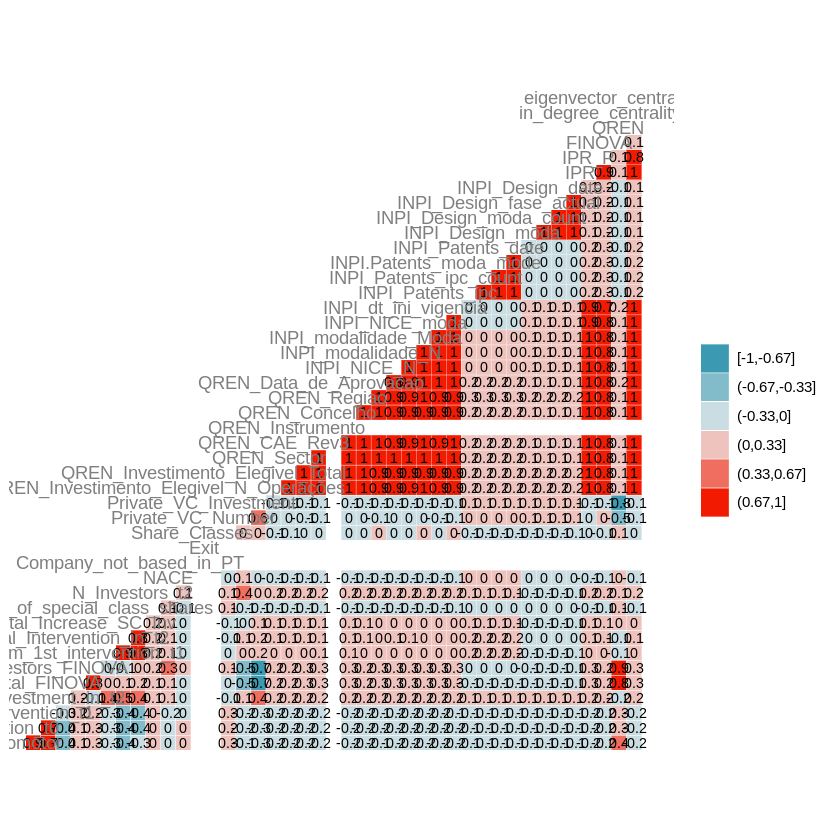

In [71]:
library(GGally)

corr <- data.frame(lapply(Finaltable, as.integer))
# Plot the graphggcorr(using GGally)
ggcorr(corr, method = c("everything", "spearman"), nbreaks = 6,
hjust = 0.8,label = TRUE, label_size = 3, color = "grey50")


## Dependent (response) Variable

### IPR P (Existance of IPR) >=1

* Frequency table (dependant variable)

In [72]:
table <- table(Finaltable$IPR_P)
table


  0   1 
141  34 

* Proportions

In [73]:
prop.table(table)


        0         1 
0.8057143 0.1942857 

Warning message:
“Use of `Finaltable$IPR_P` is discouraged. Use `IPR_P` instead.”


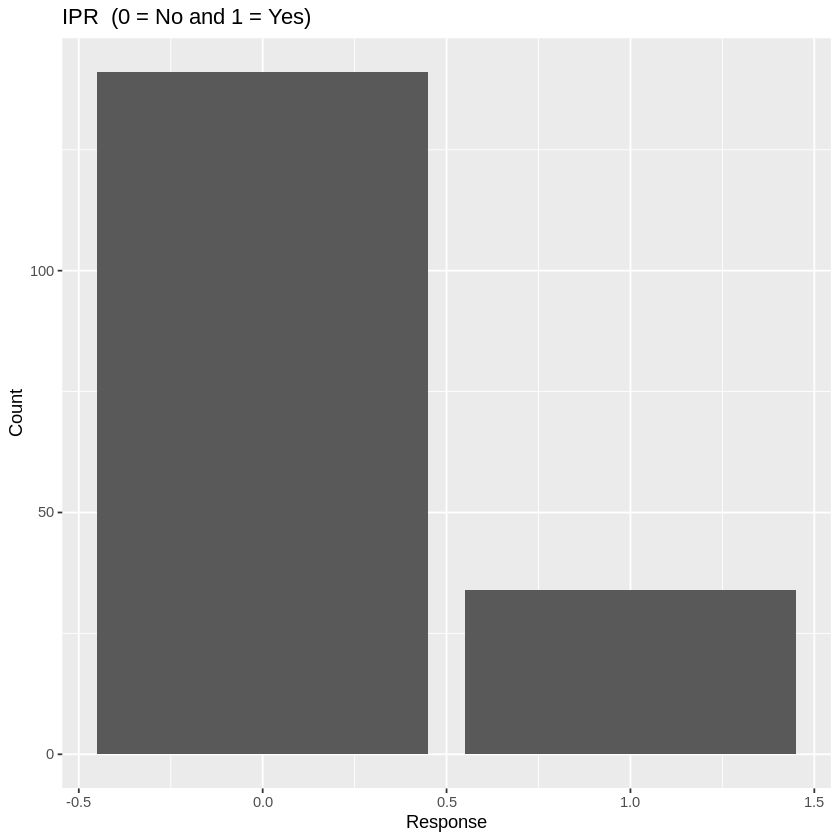

In [74]:
library(ggplot2)
g <- ggplot(Finaltable, aes(Finaltable$IPR_P))
g + geom_bar() + labs(title= "IPR \ (0 = No and 1 = Yes)",  y="Count", x = "Response")

## Predictors

### QREN

In [75]:
table3 <- table(Finaltable$QREN)
table3


  0   1 
128  47 

In [76]:
prop.table(table3)


        0         1 
0.7314286 0.2685714 

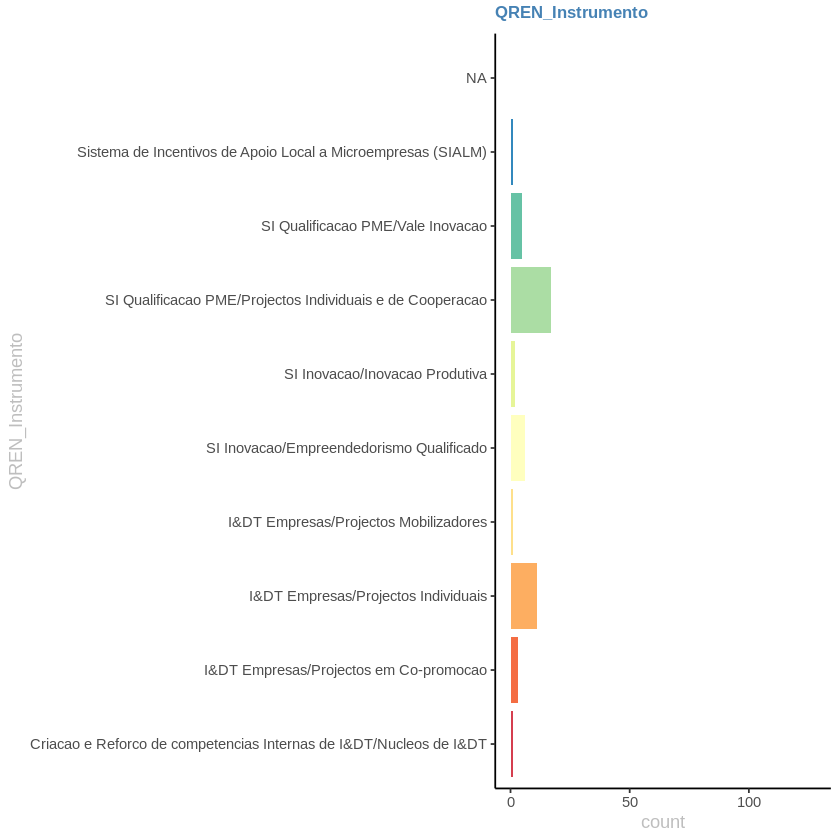

In [77]:
QREN_Instrumento <-ggplot(Finaltable, aes(x = QREN_Instrumento, fill=QREN_Instrumento)) + geom_bar() + coord_flip() + ggtitle("QREN_Instrumento") + xlab("") + scale_fill_brewer(palette="Spectral") + labs(x = "QREN_Instrumento", fill = "Legenda") + theme_classic() + theme(legend.position="none") + theme(axis.title = element_text(size = rel(1), colour = "grey")) + theme(plot.title = element_text(size = 10, vjust = 2, colour = "steelblue", face = "bold")) + theme(axis.title = element_text(size = rel(1), colour = "grey"))

QREN_Instrumento

#### Transformation (-> log)

In [78]:
Finaltable$QREN_Investimento_Elegivel_Total_log <- log(Finaltable$QREN_Investimento_Elegivel_Total)

In [79]:
Finaltable$QREN_Investimento_Elegivel_Total

[1]        0        0        0   879823   406265   510525        0        0
  [9]        0        0        0        0        0   929700   505980        0
 [17]        0   200712        0        0        0        0   274523    20000
 [25]        0   420664        0   595052        0        0        0        0
 [33]        0        0        0        0        0        0        0        0
 [41]        0        0        0        0        0  1509048  2413337   334680
 [49]        0   726203        0        0   196739        0   295791        0
 [57]    15000        0        0        0        0        0        0        0
 [65]        0        0   722801   100464  1012296 19560891   878031   280016
 [73]        0        0        0        0        0        0    70572   352179
 [81]   216470        0   228253        0   159820    41458        0        0
 [89]        0        0        0        0        0        0   272984        0
 [97]        0   101633        0        0   259174        0        0        0
[105]        0        0        0        0        0    10422        0        0
[113]   173758  2384160        0        0        0        0   592074        0
[121]        0        0   546226        0        0        0        0  3299972
[129]   380118        0        0  3663250        0        0        0        0
[137]        0        0        0        0  2651178   765361        0        0
[145]        0        0        0        0        0        0        0        0
[153]   824263        0        0        0        0        0  1674023        0
[161]        0   546470        0        0        0        0        0        0
[169]        0        0        0  4907440   782763        0        0

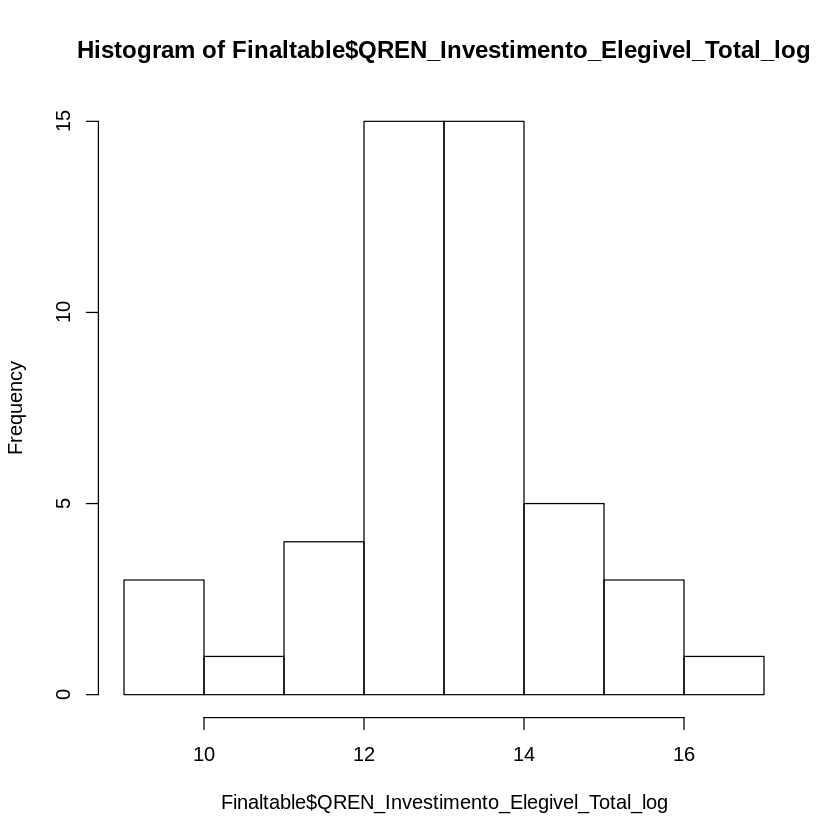

In [80]:
hist(Finaltable$QREN_Investimento_Elegivel_Total_log)

Warning message:
“Removed 128 rows containing non-finite values (stat_density).”


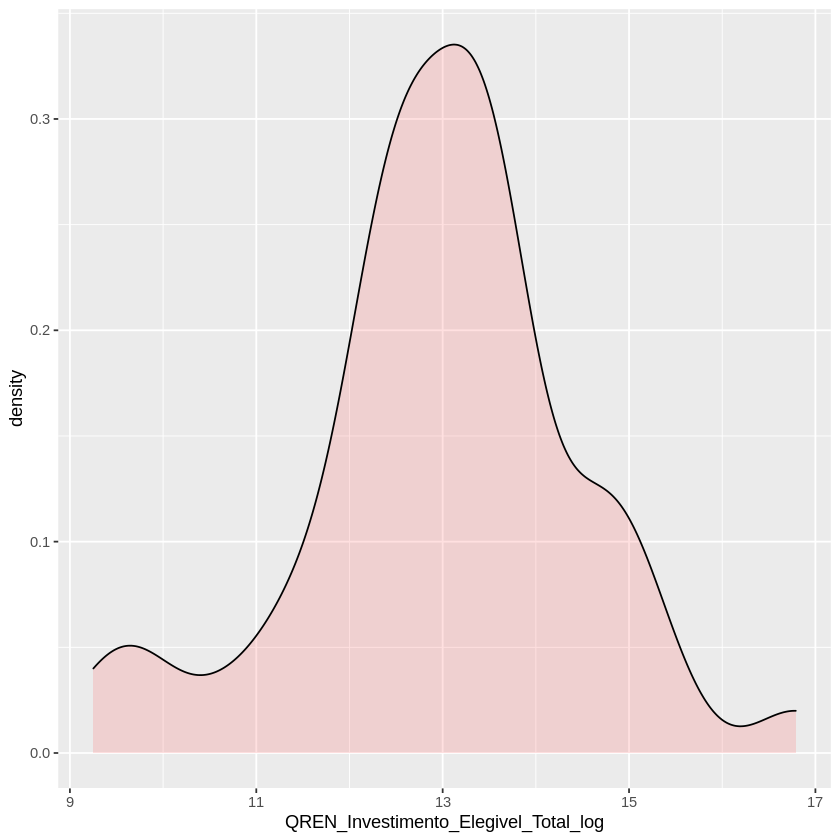

In [81]:
# Histogram with kernel density curve
ggplot(Finaltable, aes(x = QREN_Investimento_Elegivel_Total_log)) +
    geom_density(alpha = .2, fill = "#FF6666")


Warning message:
“Removed 128 rows containing non-finite values (stat_ecdf).”


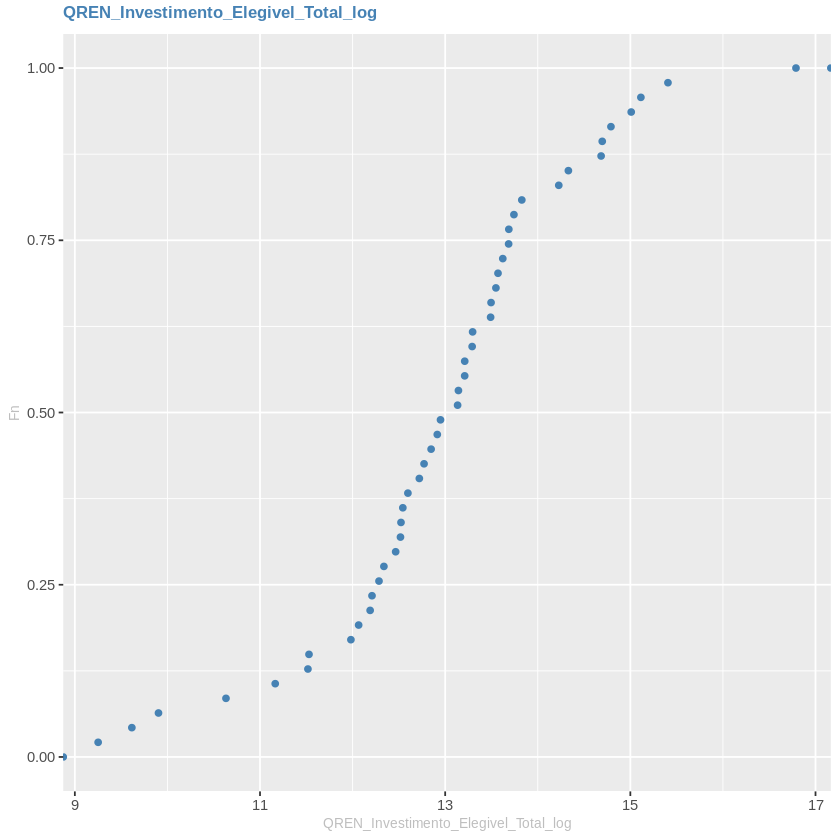

In [82]:
# ecdf
Total.aum.inv_ecdf <- ggplot(Finaltable, aes(QREN_Investimento_Elegivel_Total_log)) + stat_ecdf(geom = "point", colour = "steelblue") +  ylab("Fn") + ggtitle("QREN_Investimento_Elegivel_Total_log") + theme(axis.title = element_text(size = rel(0.75), colour = "grey")) + theme(plot.title = element_text(size = 10, vjust = 2, colour = "steelblue", face = "bold")) + theme(axis.title = element_text(size = rel(0.75), colour = "grey"))

Total.aum.inv_ecdf

### FIN0VA

In [83]:
table4 <- table(Finaltable$FINOVA)
table4


  0   1 
 54 121 

In [84]:
prop.table(table4)


        0         1 
0.3085714 0.6914286 

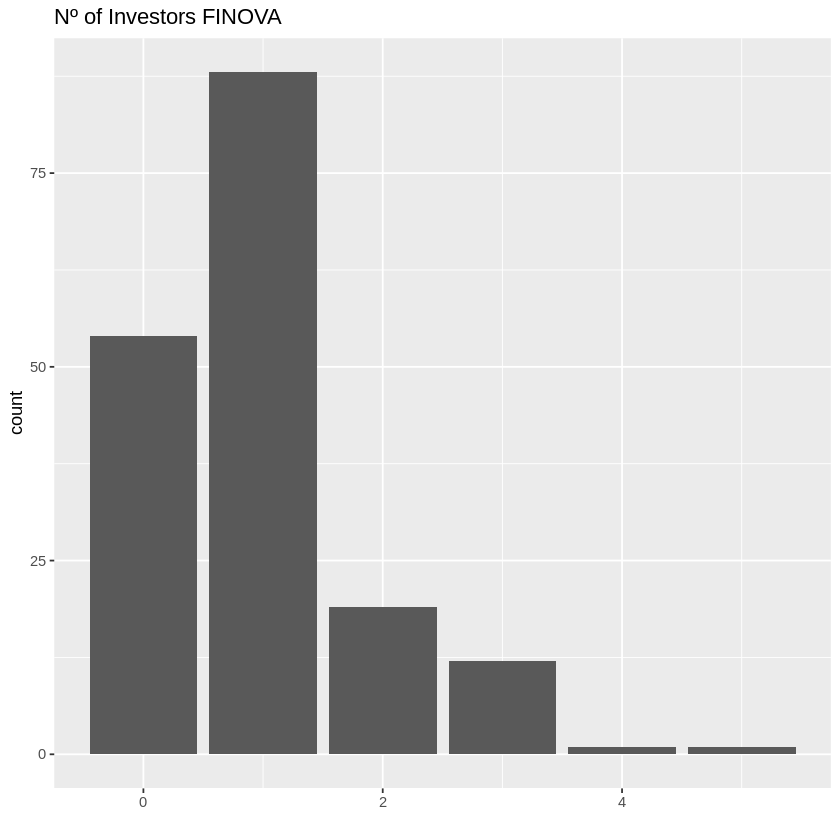

In [85]:
gfin <- ggplot(Finaltable, aes(x = N_Investors_FINOVA)) + geom_bar() + ggtitle("Nº of Investors FINOVA") + xlab("") + scale_fill_brewer(palette="Spectral") + labs(x = "", fill = "Legenda")

gfin 

### Network measures (In Degree Centrality)

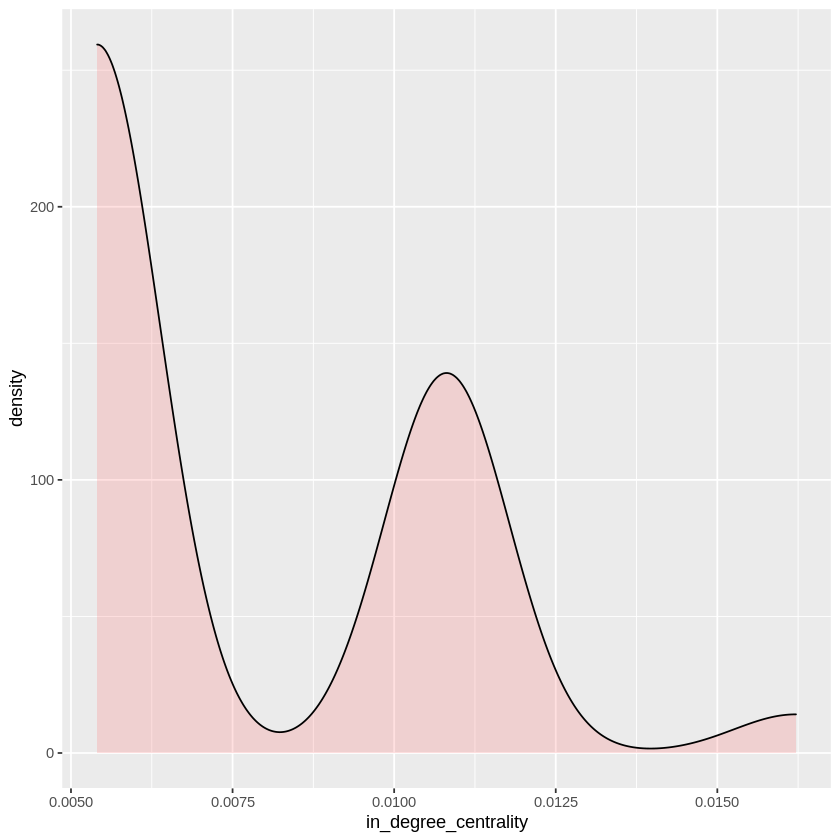

In [86]:
# Histogram with kernel density curve
ggplot(Finaltable, aes(x = in_degree_centrality)) +
    geom_density(alpha = .2, fill = "#FF6666")

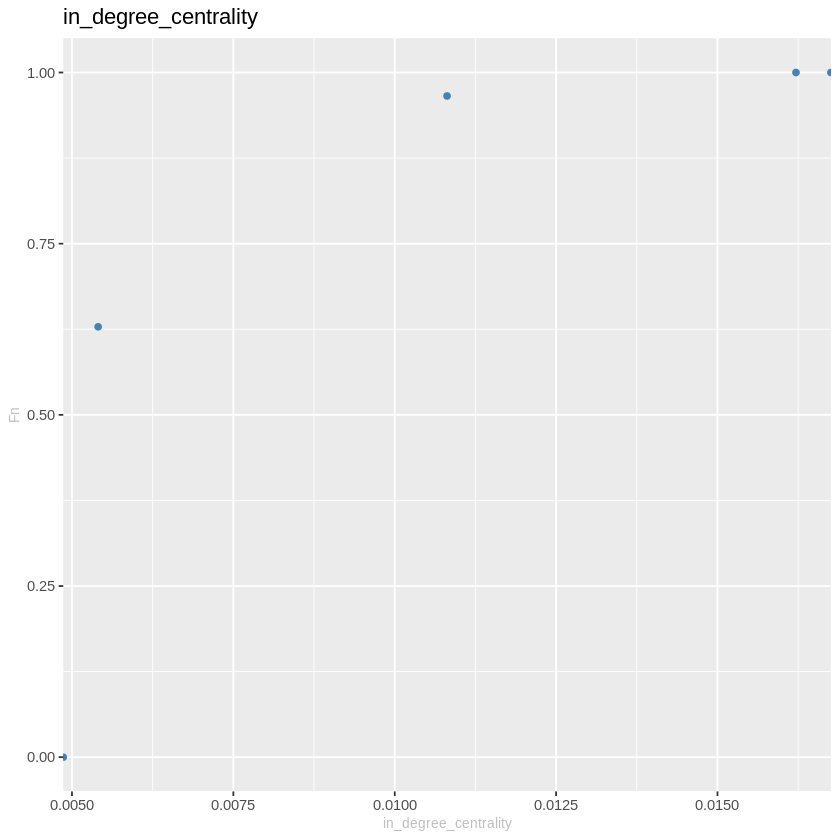

In [87]:
# ecdf
in_degree_centrality_ecdf <- ggplot(Finaltable, aes(in_degree_centrality)) + stat_ecdf(geom = "point", colour = "steelblue") +  ylab("Fn") + ggtitle("in_degree_centrality") + theme(axis.title = element_text(size = rel(0.75), colour = "grey")) + theme(axis.title = element_text(size = rel(0.75), colour = "grey"))

in_degree_centrality_ecdf

### NACE

In [88]:
table5 <- table(Finaltable$NACE)
table5


                                                       C - Manufacturing 
                                                                      22 
                 D - Electricity, gas, steam and air conditioning supply 
                                                                       1 
                                                        F - Construction 
                                                                       1 
G - Wholesale and retail trade, repair of motor vehicles and motorcycles 
                                                                       9 
                                       J - Information and communication 
                                                                      82 
                                  K - Financial and insurance activities 
                                                                       4 
                                              L - Real estate activities 
                                     

In [89]:
prop.table(table5)


                                                       C - Manufacturing 
                                                             0.125714286 
                 D - Electricity, gas, steam and air conditioning supply 
                                                             0.005714286 
                                                        F - Construction 
                                                             0.005714286 
G - Wholesale and retail trade, repair of motor vehicles and motorcycles 
                                                             0.051428571 
                                       J - Information and communication 
                                                             0.468571429 
                                  K - Financial and insurance activities 
                                                             0.022857143 
                                              L - Real estate activities 
                                     

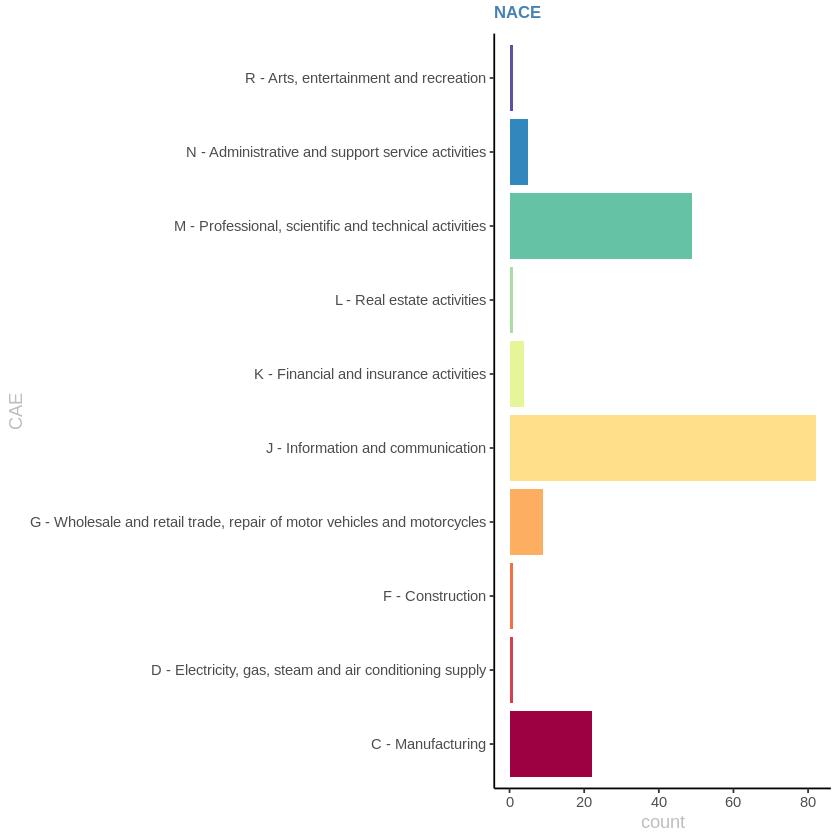

In [90]:
NACE <-ggplot(Finaltable, aes(x = NACE, fill=NACE)) + geom_bar() + coord_flip() + ggtitle("NACE") + xlab("") + scale_fill_brewer(palette="Spectral") + labs(x = "CAE", fill = "Legenda") + theme_classic() + theme(legend.position="none") + theme(axis.title = element_text(size = rel(1), colour = "grey")) + theme(plot.title = element_text(size = 10, vjust = 2, colour = "steelblue", face = "bold")) + theme(axis.title = element_text(size = rel(1), colour = "grey"))

NACE

In [91]:
summary(Finaltable$NACE)

C - Manufacturing 
                                                                      22 
                 D - Electricity, gas, steam and air conditioning supply 
                                                                       1 
                                                        F - Construction 
                                                                       1 
G - Wholesale and retail trade, repair of motor vehicles and motorcycles 
                                                                       9 
                                       J - Information and communication 
                                                                      82 
                                  K - Financial and insurance activities 
                                                                       4 
                                              L - Real estate activities 
                                                                       1 
                   M - Professional, scientific and technical activities 
                                                                      49 
                       N - Administrative and support service activities 
                                                                       5 
                                  R - Arts, entertainment and recreation 
                                                                       1

## Principal Component Analysis (PCA) 

In [92]:
Finaltable$in_degree_centrality100 <- Finaltable$in_degree_centrality*100

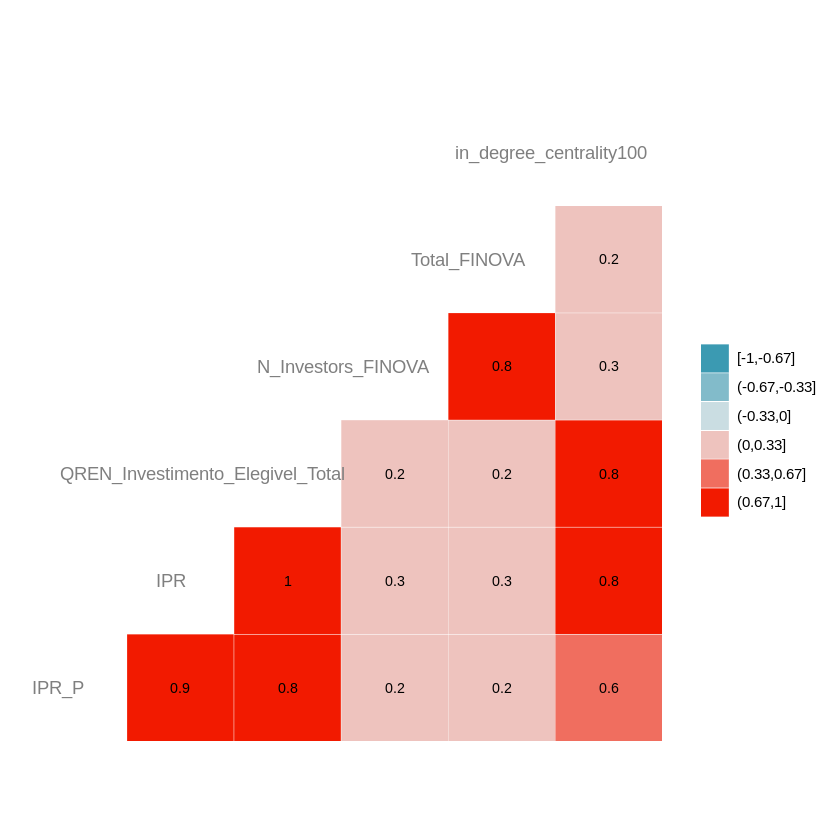

In [93]:
library(GGally)
plist <- c('IPR_P', 'IPR', "QREN_Investimento_Elegivel_Total", "N_Investors_FINOVA","Total_FINOVA", "in_degree_centrality100")
newdata <- Finaltable[plist]
#"NACE"
corr <- data.frame(lapply(newdata, as.integer))
# Plot the graphggcorr(using GGally)
ggcorr(corr, method = c("everything", "spearman"), nbreaks = 6,
hjust = 0.8,label = TRUE, label_size = 3, color = "grey50")

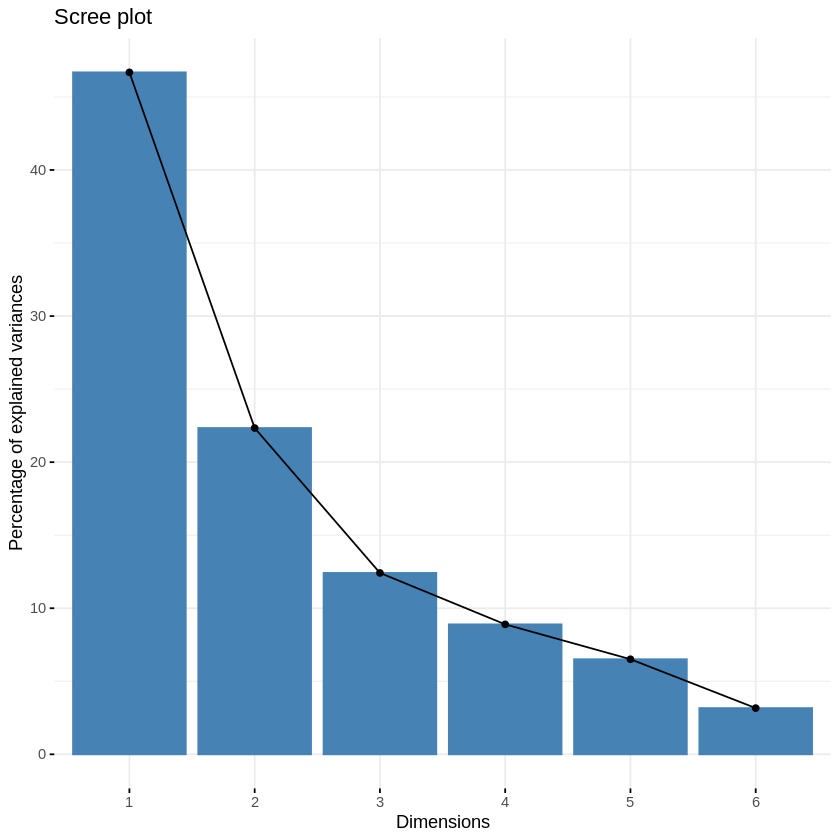

In [94]:
library(magrittr) # for pipe %>%
library(dplyr)   # everything else
library(farver)
library(factoextra)
res.pca <- prcomp(corr, scale = TRUE)
fviz_eig(res.pca)

In [95]:
summary(res.pca)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6
Standard deviation     1.6736 1.1576 0.8631 0.73055 0.62487 0.43564
Proportion of Variance 0.4668 0.2233 0.1242 0.08895 0.06508 0.03163
Cumulative Proportion  0.4668 0.6902 0.8143 0.90329 0.96837 1.00000

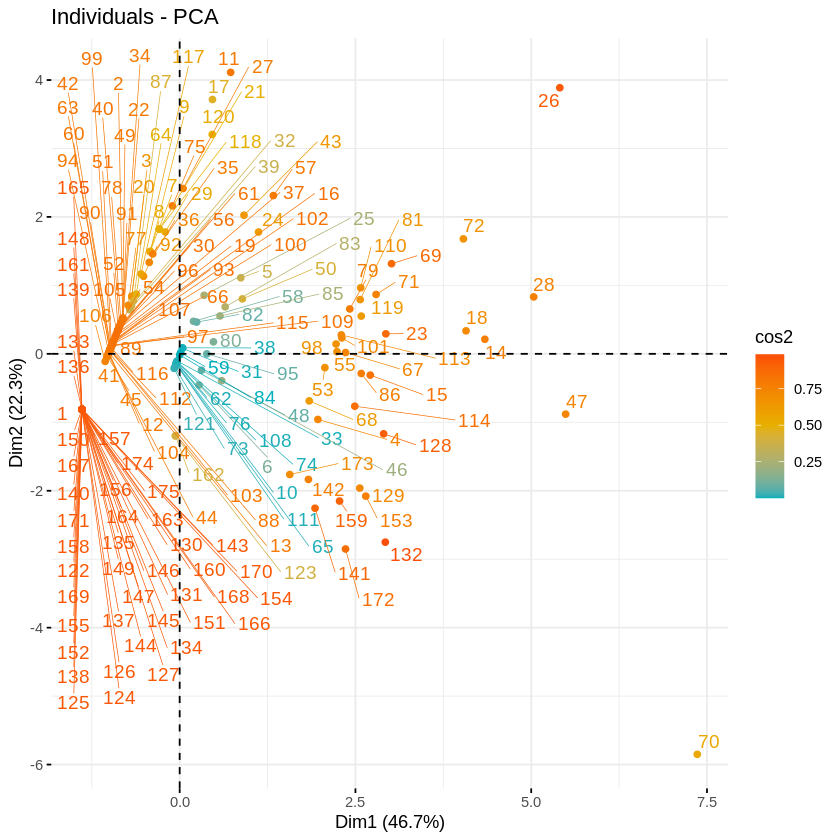

In [96]:
library(farver)
fviz_pca_ind(res.pca,
             col.ind = "cos2", # Color by the quality of representation
             gradient.cols = c('#00AFBB', '#E7B000','#FC4E07'),
             repel = TRUE     # Avoid text overlapping
             )

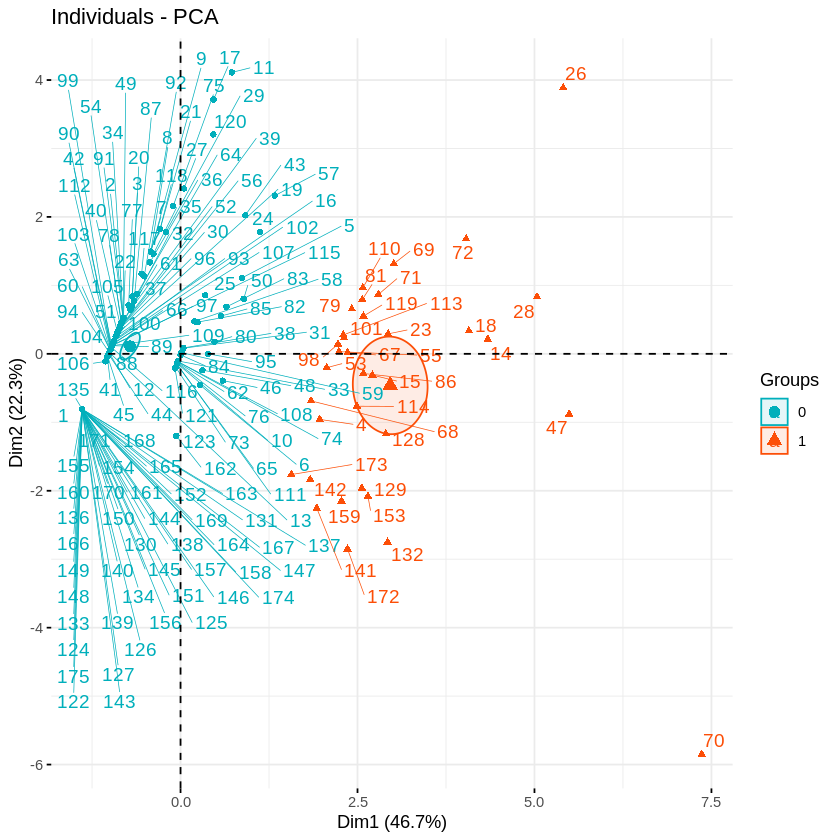

In [97]:
groups <- as.factor(newdata$IPR_P[1:175])
fviz_pca_ind(res.pca,
             col.ind = groups, # color by groups
             palette = c("#00AFBB",  "#FC4E07"),
             addEllipses = TRUE, # Concentration ellipses
             ellipse.type = "confidence",
             legend.title = "Groups",
             repel = TRUE
             )

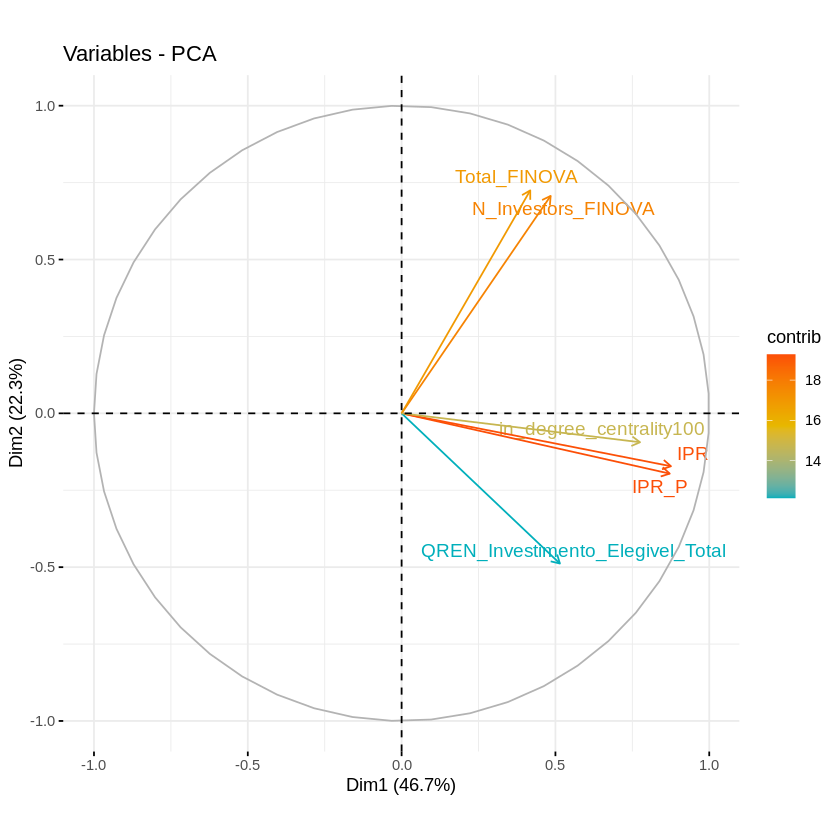

In [98]:
library(magrittr) # for pipe %>%
library(dplyr)   # everything else
library(farver)
fviz_pca_var(res.pca,
             col.var = "contrib", # Color by contributions to the PC
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE     # Avoid text overlapping
             )

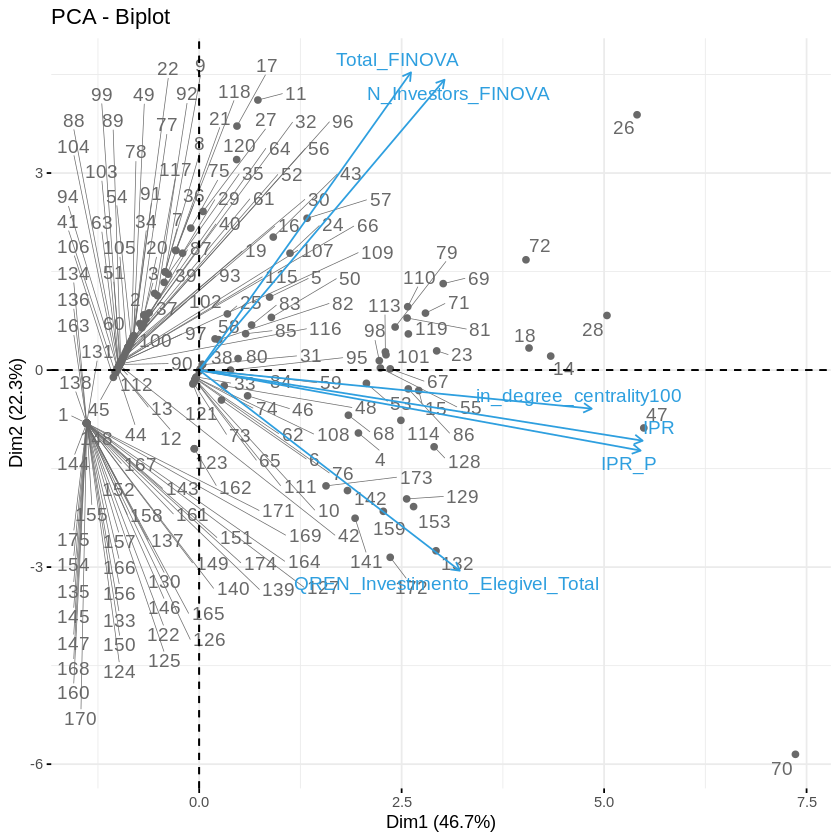

In [99]:
fviz_pca_biplot(res.pca, repel = TRUE,
                col.var = "#2E9FDF", # Variables color
                col.ind = "#696969"  # Individuals color
                )

## Probit Regression

A probit regression is a version of the generalized linear model used to model dichotomous outcome variables. It uses the inverse standard normal distribution as a linear combination of the predictors. The binary outcome variable Y is assumed to have a Bernoulli distribution with parameter $p$ (where the success probability is $p\in(0,1)$). Hence, the probit link function is

$$\Phi^{-1}(\pi_{i}) = X_{i}\beta + \varepsilon _{i}$$

where

$$\Phi(Z) = \int_{-\propto}^{Z}\frac{1}{\sqrt2\pi}e^{\frac{1}{2}t^{2}}dt.$$


This is the cumulative normal distribution
$\Phi$ That is, given any Z-score, $\Phi(Z)\in[0,1]$

So we would say that
$$Y =\Phi(X\beta + \varepsilon)$$
$$\Phi^{-1}(Y)= X\beta + \varepsilon$$
$$Y′ = X\beta + \varepsilon$$

Link function is $F(Y)=\Phi^{-1}(Y)$ 


In [100]:
No_Predictor <-glm(Finaltable$IPR_P~1,Finaltable,family = binomial(link= "probit"))
summary(No_Predictor)


Call:
glm(formula = Finaltable$IPR_P ~ 1, family = binomial(link = "probit"), 
    data = Finaltable)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6573  -0.6573  -0.6573  -0.6573   1.8102  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.8622     0.1087  -7.931 2.18e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 172.33  on 174  degrees of freedom
Residual deviance: 172.33  on 174  degrees of freedom
AIC: 174.33

Number of Fisher Scoring iterations: 4


In [101]:
library(stargazer)
stargazer(No_Predictor, type = 'text', no.space = TRUE)


                      Dependent variable:    
                  ---------------------------
                             IPR_P           
---------------------------------------------
Constant                   -0.862***         
                            (0.109)          
---------------------------------------------
Observations                  175            
Log Likelihood              -86.166          
Akaike Inf. Crit.           174.332          
Note:             *p<0.1; **p<0.05; ***p<0.01


In [102]:
Probit = glm(Finaltable$IPR_P ~ Finaltable$QREN_Investimento_Elegivel_Total + Finaltable$N_Investors_FINOVA  + Finaltable$in_degree_centrality + Finaltable$NACE, data= Finaltable, binomial(link= "probit"))
summary(Probit)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = Finaltable$IPR_P ~ Finaltable$QREN_Investimento_Elegivel_Total + 
    Finaltable$N_Investors_FINOVA + Finaltable$in_degree_centrality + 
    Finaltable$NACE, family = binomial(link = "probit"), data = Finaltable)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.50600  -0.16342  -0.08589  -0.04592   1.95374  

Coefficients:
                                                                                          Estimate
(Intercept)                                                                             -3.887e+00
Finaltable$QREN_Investimento_Elegivel_Total                                              2.067e-06
Finaltable$N_Investors_FINOVA                                                            3.947e-01
Finaltable$in_degree_centrality                                                          2.357e+02
Finaltable$NACED - Electricity, gas, steam and air conditioning supply                  -2.963e+00
Finaltable$NACEF - Construction  

In [103]:
library(stargazer)
stargazer(Probit, type = 'text', no.space = TRUE)


                                                                                 Dependent variable:    
                                                                             ---------------------------
                                                                                        IPR_P           
--------------------------------------------------------------------------------------------------------
QREN_Investimento_Elegivel_Total                                                     0.00000***         
                                                                                      (0.00000)         
N_Investors_FINOVA                                                                     0.395**          
                                                                                       (0.185)          
in_degree_centrality                                                                 235.747***         
                                                      

`geom_smooth()` using formula 'y ~ x'

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


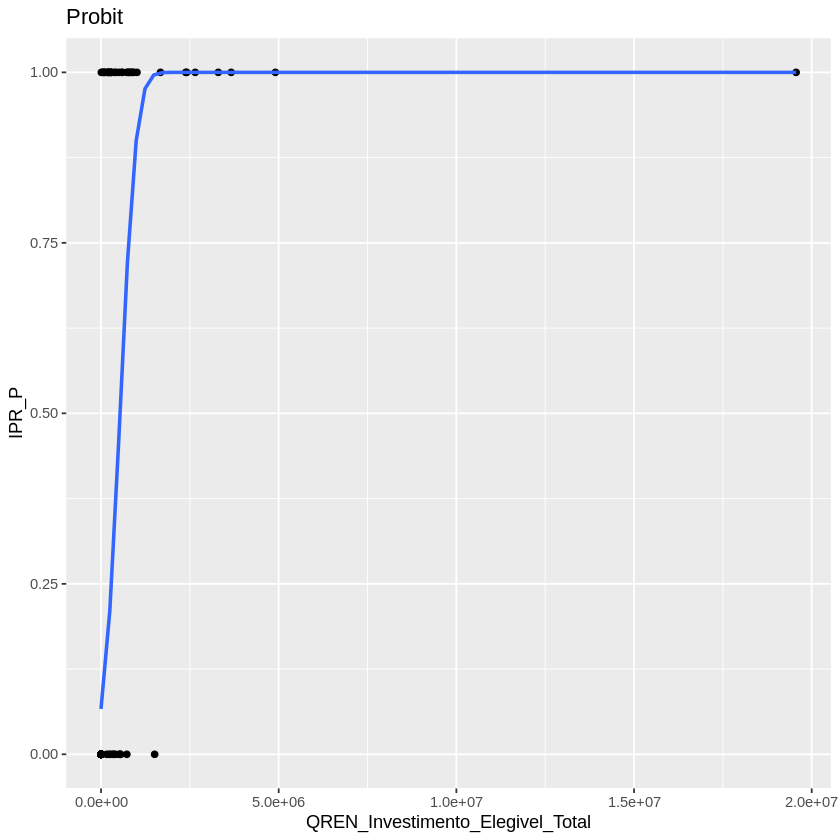

In [104]:
library(tidyverse)

Finaltable %>% 
  ggplot(aes(x = QREN_Investimento_Elegivel_Total, y = IPR_P)) + 
  geom_point() +
  geom_smooth(method = "glm", method.args=list(family=binomial(link = "probit")), se = F) + 
  ggtitle("Probit")

`geom_smooth()` using formula 'y ~ x'



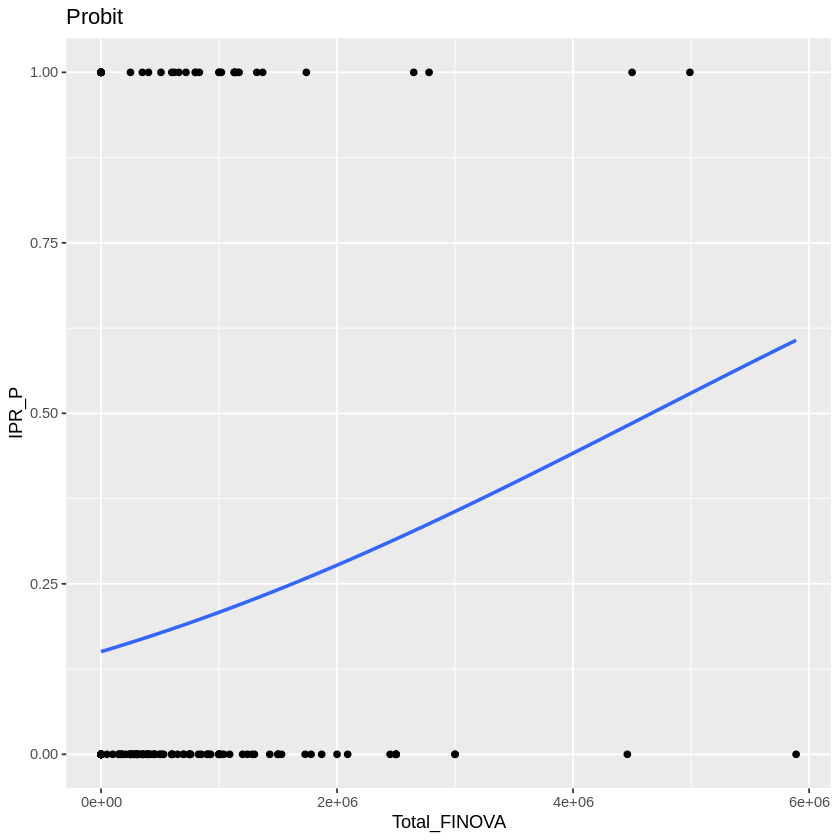

In [105]:
library(tidyverse)

Finaltable %>% 
  ggplot(aes(x = Total_FINOVA, y = IPR_P)) + 
  geom_point() +
  geom_smooth(method = "glm", method.args=list(family=binomial(link = "probit")), se = F) + 
  ggtitle("Probit")

`geom_smooth()` using formula 'y ~ x'



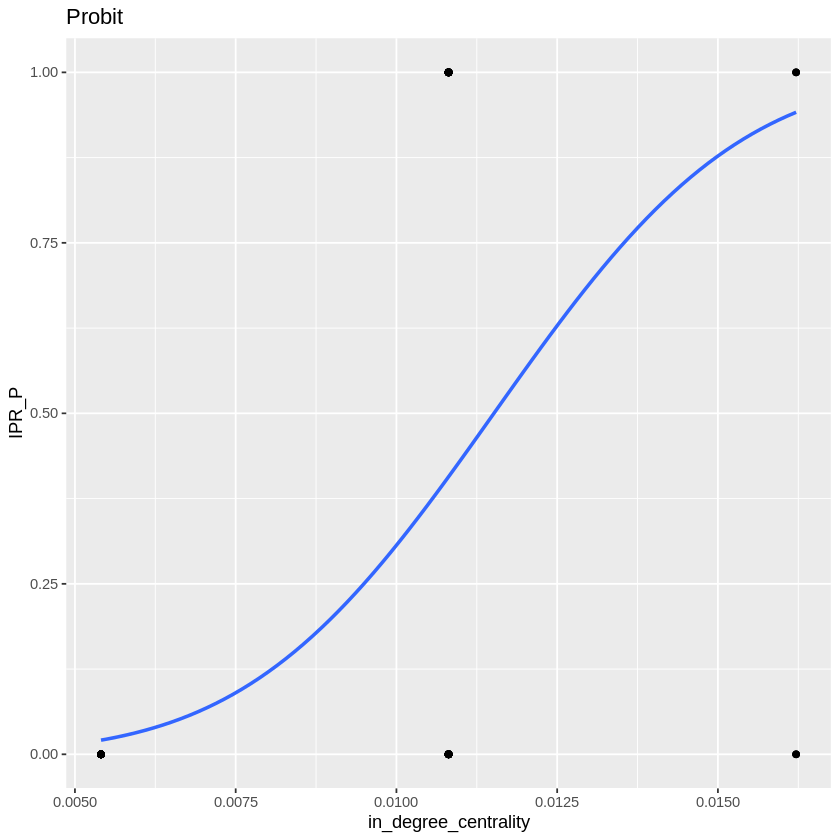

In [106]:
library(tidyverse)
Finaltable %>% 
  ggplot(aes(x = in_degree_centrality, y = IPR_P)) + 
  geom_point() +
  geom_smooth(method = "glm", method.args=list(family=binomial(link = "probit")), se = F) + 
  ggtitle("Probit")

In [107]:
confint(Probit)

Waiting for profiling to be done...

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted proba

,2.5 %,97.5 %
(Intercept),-5.830658e+00,-2.409840e+00
Finaltable$QREN_Investimento_Elegivel_Total,1.138277e-06,3.124751e-06
Finaltable$N_Investors_FINOVA,2.301289e-02,7.731372e-01
Finaltable$in_degree_centrality,1.153783e+02,3.802987e+02
"Finaltable$NACED - Electricity, gas, steam and air conditioning supply",NA,1.950802e+02
Finaltable$NACEF - Construction,-1.919371e+02,NA
"Finaltable$NACEG - Wholesale and retail trade, repair of motor vehicles and motorcycles",-1.674049e+00,1.276806e+00
Finaltable$NACEJ - Information and communication,-1.468520e+00,5.602451e-01
Finaltable$NACEK - Financial and insurance activities,NA,4.895463e+01
Finaltable$NACEL - Real estate activities,NA,1.950802e+02


The estimated model equation is
  

* (constant) given that all predictors are set to their mean values.

### Marginal Effects

#### Marginal effects interpretation:
 
* It is interpreted as both the sign and the magnitude of the marginal effects.
 
* The marginal effects at the mean and the average marginal effects are almost identical.
 
* An increase in x increases (decreases) the probability that y=1 by the marginal effect expressed as a percent.
 - For dummy independent variables, the marginal effect is expressed in comparison to the base category (x=0).
 - For continuous independent variables, the marginal effect is expressed for a one-unit change in x.
 

### Using Partial Effects at the Average (PEA):

In [108]:
library("mfx")
#probitmfx(dataPTsample_imp$dataPT.Y16_Q89a ~ dataPTsample_imp$dataPT.Y16_Q93b + dataPTsample_imp$dataPT.Y16_Income_Equivalised_log, dataPTsample_imp)
PEA_probit = mfx::probitmfx(formula = Probit$formula, data = Probit$data, atmean = TRUE)
print(PEA_probit$mfxest)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                                                                                                dF/dx
Finaltable$QREN_Investimento_Elegivel_Total                                              3.201886e-07
Finaltable$N_Investors_FINOVA                                                            6.113948e-02
Finaltable$in_degree_centrality                                                          3.651542e+01
Finaltable$NACED - Electricity, gas, steam and air conditioning supply                  -8.712407e-02
Finaltable$NACEF - Construction                                                          9.209702e-01
Finaltable$NACEG - Wholesale and retail trade, repair of motor vehicles and motorcycles -2.556773e-02
Finaltable$NACEJ - Information and communication                                        -7.064716e-02
Finaltable$NACEK - Financial and insurance activities                                   -9.755085e-02
Finaltable$NACEL - Real estate activities                                         

In [109]:
PEA_probit$mfxest

,dF/dx,Std. Err.,z,P>|z|
Finaltable$QREN_Investimento_Elegivel_Total,3.201886e-07,6.775308e-06,0.04725816,0.9623075
Finaltable$N_Investors_FINOVA,6.113948e-02,1.293762e+00,0.04725712,0.9623083
Finaltable$in_degree_centrality,3.651542e+01,7.725189e+02,0.04726800,0.9622996
"Finaltable$NACED - Electricity, gas, steam and air conditioning supply",-8.712407e-02,2.272868e+00,-0.03833221,0.9694228
Finaltable$NACEF - Construction,9.209702e-01,2.112181e+00,0.43602815,0.6628163
"Finaltable$NACEG - Wholesale and retail trade, repair of motor vehicles and motorcycles",-2.556773e-02,5.802244e-01,-0.04406525,0.9648524
Finaltable$NACEJ - Information and communication,-7.064716e-02,1.485916e+00,-0.04754451,0.9620793
Finaltable$NACEK - Financial and insurance activities,-9.755085e-02,1.917932e+00,-0.05086252,0.9594351
Finaltable$NACEL - Real estate activities,-8.712407e-02,2.272868e+00,-0.03833221,0.9694228
"Finaltable$NACEM - Professional, scientific and technical activities",-2.789756e-02,6.114617e-01,-0.04562437,0.9636096


### Using Average Partial Effect (APE)

In [110]:
APE_probit = mfx::probitmfx(formula = Probit$formula, data = Probit$data, atmean = FALSE)
print(APE_probit$mfxest)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                                                                                                dF/dx
Finaltable$QREN_Investimento_Elegivel_Total                                              2.060001e-07
Finaltable$N_Investors_FINOVA                                                            3.933538e-02
Finaltable$in_degree_centrality                                                          2.349297e+01
Finaltable$NACED - Electricity, gas, steam and air conditioning supply                  -1.421274e-01
Finaltable$NACEF - Construction                                                          8.044045e-01
Finaltable$NACEG - Wholesale and retail trade, repair of motor vehicles and motorcycles -1.772521e-02
Finaltable$NACEJ - Information and communication                                        -4.666959e-02
Finaltable$NACEK - Financial and insurance activities                                   -1.489010e-01
Finaltable$NACEL - Real estate activities                                         

In [111]:
APE_probit$mfxest

,dF/dx,Std. Err.,z,P>|z|
Finaltable$QREN_Investimento_Elegivel_Total,2.060001e-07,4.818787e-08,4.27493710,1.911913e-05
Finaltable$N_Investors_FINOVA,3.933538e-02,1.750832e-02,2.24666742,2.466129e-02
Finaltable$in_degree_centrality,2.349297e+01,5.941121e+00,3.95429943,7.675923e-05
"Finaltable$NACED - Electricity, gas, steam and air conditioning supply",-1.421274e-01,1.364956e+01,-0.01041260,9.916921e-01
Finaltable$NACEF - Construction,8.044045e-01,1.386054e+01,0.05803560,9.537203e-01
"Finaltable$NACEG - Wholesale and retail trade, repair of motor vehicles and motorcycles",-1.772521e-02,7.327663e-02,-0.24189451,8.088619e-01
Finaltable$NACEJ - Information and communication,-4.666959e-02,5.209757e-02,-0.89581127,3.703536e-01
Finaltable$NACEK - Financial and insurance activities,-1.489010e-01,4.962770e+00,-0.03000361,9.760642e-01
Finaltable$NACEL - Real estate activities,-1.421274e-01,1.364956e+01,-0.01041260,9.916921e-01
"Finaltable$NACEM - Professional, scientific and technical activities",-1.874373e-02,5.485256e-02,-0.34171108,7.325683e-01


* The interpretation of PEA and APE of the probit model are analogous to the logit model - a unit increase in the (average, if PEA) regressor results in the specified change (or average change in the case of APE) in the probability.

* Marginal effects show the change in probability when the predictor, or independent, variable increases by one unit. For continuous variables this represents the instantaneous change given that the ‘unit’ may be very small. For binary variables, the change is from 0 to 1, so one ‘unit’ as it is usually thought.


* APE uses a vector with the mean of each X, or, the partial effect of for an "average" observation in our sample. An average observation may be very unrealistic, with binary explanatory variables.


### Goodness of fit measures

#### Confusion Matrix

In [112]:
table5 <- table(true = Finaltable$IPR_P, pred = round(fitted(Probit)))
table5

    pred
true   0   1
   0 136   5
   1   9  25

In [113]:
prop.table(table5)

    pred
true          0          1
   0 0.77714286 0.02857143
   1 0.05142857 0.14285714

In [114]:
0.77714286 + 0.14285714

[1] 0.92

aprox 92% correctly classified and 8% misclassified

In [115]:
predicted.data <- data.frame(
  probability.of.hd=Probit$fitted.values,
  ipr=Finaltable$IPR_P)

In [116]:
predicted <- predict(Probit, Finaltable, type="response")

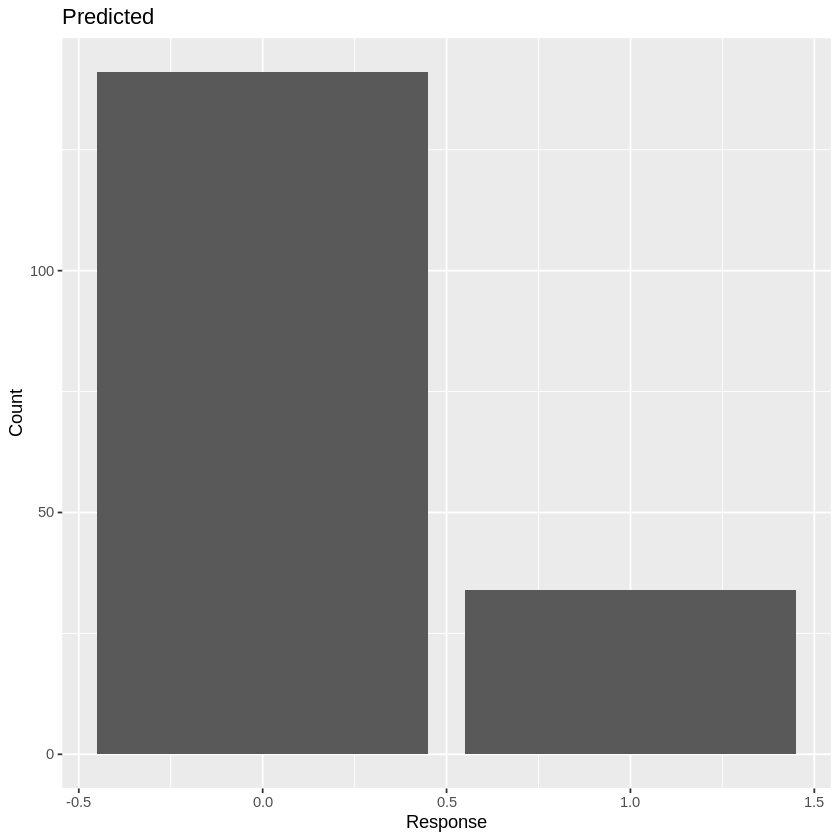

In [117]:
g4 <- ggplot(predicted.data, aes(ipr))
g4 + geom_bar() + labs(title= "Predicted",  y="Count", x = "Response")

### Receiver Operating Characteristics (ROC) Curve
percentage of true positives accurately predicted as the prediction probability cutoff is lowered from 1 to 0. ROC summarizes the model’s performance by evaluating the trade-offs between true positive rate (sensitivity) and false positive rate (1- specificity).

Warning message:
“Removed 20 rows containing missing values (geom_text).”


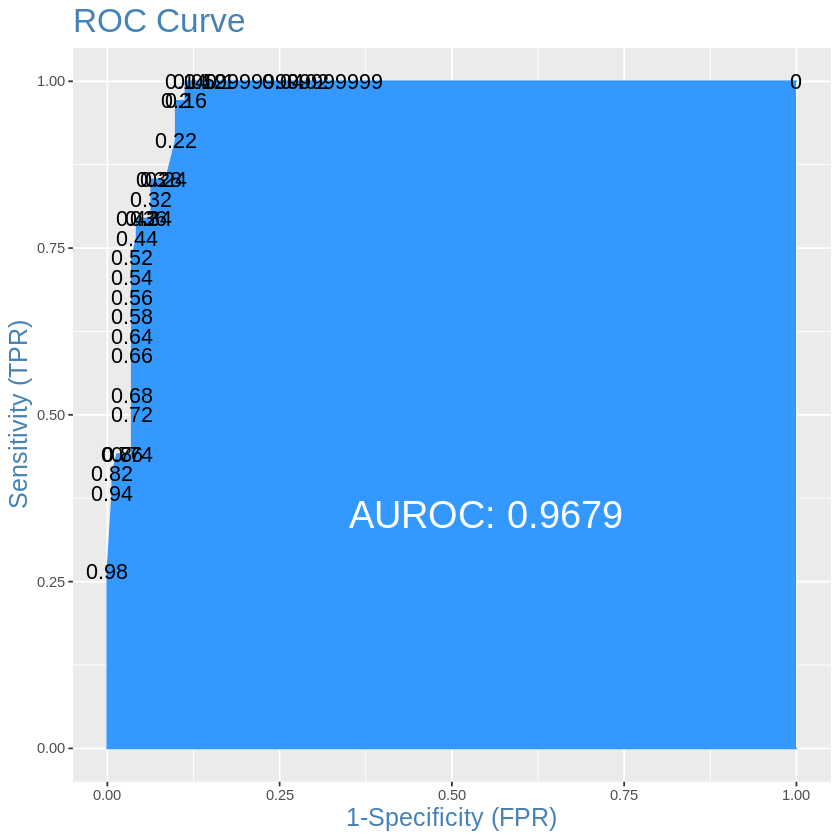

In [118]:
library(InformationValue)
InformationValue::plotROC(Finaltable$IPR_P, predicted , Show.labels = TRUE)

In [119]:
coeftest(Probit, vcov. = vcovHC, type = "HC1")


z test of coefficients:

                                                                                           Estimate
(Intercept)                                                                             -3.8874e+00
Finaltable$QREN_Investimento_Elegivel_Total                                              2.0672e-06
Finaltable$N_Investors_FINOVA                                                            3.9472e-01
Finaltable$in_degree_centrality                                                          2.3575e+02
Finaltable$NACED - Electricity, gas, steam and air conditioning supply                  -2.9628e+00
Finaltable$NACEF - Construction                                                          6.3123e+00
Finaltable$NACEG - Wholesale and retail trade, repair of motor vehicles and motorcycles -1.8542e-01
Finaltable$NACEJ - Information and communication                                        -4.6158e-01
Finaltable$NACEK - Financial and insurance activities                     

### Heteroskedasticity-robust standard errors of the coefficient estimators

In [120]:
rob_se <- (sqrt(diag(vcovHC(Probit, type = "HC1"))))

In [121]:
stargazer(Probit,  
          digits = 3,
          type = "text", 
          header = FALSE,
          se = rob_se,
          no.space = TRUE,
          model.numbers = FALSE)


                                                                                 Dependent variable:    
                                                                             ---------------------------
                                                                                        IPR_P           
--------------------------------------------------------------------------------------------------------
QREN_Investimento_Elegivel_Total                                                       0.00000          
                                                                                                        
N_Investors_FINOVA                                                                      0.395           
                                                                                                        
in_degree_centrality                                                                   235.747          
                                                      

### Checking for Multicollinearity - VIF
(values are below 5, then there are no collinearity problems)

In [122]:
vif <- car::vif(Probit)
print(vif)

                                                GVIF Df GVIF^(1/(2*Df))
Finaltable$QREN_Investimento_Elegivel_Total 1.127447  1        1.061813
Finaltable$N_Investors_FINOVA               1.088388  1        1.043258
Finaltable$in_degree_centrality             1.179621  1        1.086103
Finaltable$NACE                             1.167025  9        1.008618


In [123]:
# McFadden's Pseudo R-squared
pseudoR2 <- 1 - (Probit$deviance) / (Probit$null.deviance) #McFadden
pseudoR2

[1] 0.6228559

The Pseudo Pseudo R-squared) was 62,2%, implying that the model explained about 68,8% of the deviations in the probability.

## Residuals

In the probit model, the inverse standard normal distribution of the probability is modeled as a linear combination of the predictors.
tensively. Not much has been proposed in the literature for categorical models.

Residuals and Diagnostics for Binary and Ordinal Regression Models: An Introduction to the sure Package
https://journal.r-project.org/archive/2018/RJ-2018-004/RJ-2018-004.pdf

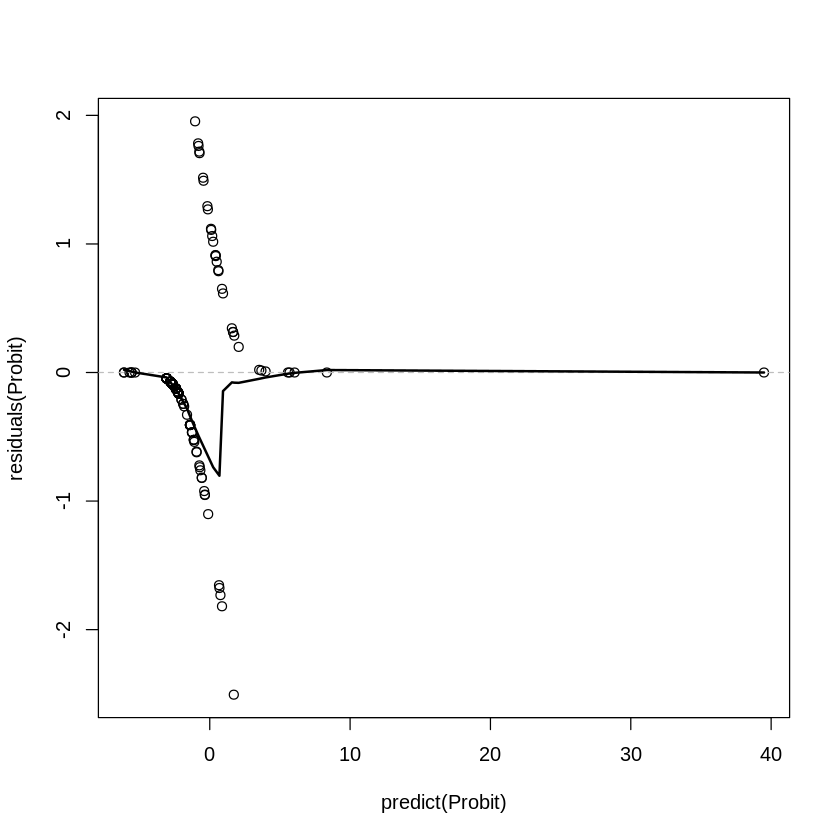

In [124]:
plot(predict(Probit),residuals(Probit))
abline(h=0,lty=2,col="grey")
lines(lowess(predict(Probit),residuals(Probit)),col="black",lwd=2)

In [125]:
sum(residuals(Probit, type = "deviance")^2) #Sums of squares:

[1] 64.9941

In [126]:
sum(residuals(Probit, type = "pearson")^2) #standardized residuals

[1] 76.4615

## Causal Effects

## Targeted maximum likelihood estimation (TMLE) 

In [127]:
library('tmle')
library('dbarts')
library('gam')

Finaltable$N_Investors_FINOVA  <- as.integer(Finaltable$N_Investors_FINOVA) 
Finaltable$QREN <- as.integer(Finaltable$QREN) 

W <- cbind(Finaltable$N_Investors_FINOVA, Finaltable$in_degree_centrality) #covarites
Y <- Finaltable$IPR_P #outcome
A <- Finaltable$QREN #Instrumental

result <- tmle(Y,A,W)

In [128]:
summary(result)

 Initial estimation of Q
	 Procedure: cv-SuperLearner, ensemble
	 Model:
		 Y ~  SL.glm_All + tmle.SL.dbarts2_All + SL.glmnet_All

	 Coefficients: 
	      SL.glm_All    0 
	 tmle.SL.dbarts2_All    0.002266154 
	   SL.glmnet_All    0.9977338 

	 Cross-validated R squared :  0.6502 

 Estimation of g (treatment mechanism)
	 Procedure: SuperLearner, ensemble	 Empirical AUC = 0.9711 

	 Model:
		 A ~  SL.glm_All + tmle.SL.dbarts.k.5_All + SL.gam_All 

	 Coefficients: 
	      SL.glm_All    0 
	 tmle.SL.dbarts.k.5_All    0.9114623 
	      SL.gam_All    0.0885377 

 Estimation of g.Z (intermediate variable assignment mechanism)
	 Procedure: No intermediate variable 

 Estimation of g.Delta (missingness mechanism)
	 Procedure: No missingness, ensemble

 Bounds on g: (0.0732, 1) 

 Bounds on g for ATT/ATE: (0.0732, 0.9268) 

 Additive Effect
   Parameter Estimate:  0.71201
   Estimated Variance:  0.00069478
              p-value:  <2e-16
    95% Conf Interval: (0.66035, 0.76367) 

 Additive Eff

Correlation Matrix

In [129]:
correlationmatrix <- cor(corr, method = c("spearman"))
correlationmatrix

,IPR_P,IPR,QREN_Investimento_Elegivel_Total,N_Investors_FINOVA,Total_FINOVA,in_degree_centrality100
IPR_P,1.0000000,0.8794590,0.8201004,0.2368083,0.1882049,0.6388069
IPR,0.8794590,1.0000000,0.9783957,0.2578384,0.2539575,0.7766121
QREN_Investimento_Elegivel_Total,0.8201004,0.9783957,1.0000000,0.2206157,0.2132600,0.7756459
N_Investors_FINOVA,0.2368083,0.2578384,0.2206157,1.0000000,0.7848658,0.3208391
Total_FINOVA,0.1882049,0.2539575,0.2132600,0.7848658,1.0000000,0.2457183
in_degree_centrality100,0.6388069,0.7766121,0.7756459,0.3208391,0.2457183,1.0000000


In [130]:
poisson = glm(Finaltable$IPR ~ Finaltable$`QREN_Investimento_Elegivel_N_Operações` + Finaltable$Total_FINOVA  + Finaltable$in_degree_centrality, Finaltable,family ="poisson")
summary(poisson)


Call:
glm(formula = Finaltable$IPR ~ Finaltable$QREN_Investimento_Elegivel_N_Operações + 
    Finaltable$Total_FINOVA + Finaltable$in_degree_centrality, 
    family = "poisson", data = Finaltable)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3415  -0.6489  -0.5490  -0.5203   4.1118  

Coefficients:
                                                    Estimate Std. Error z value
(Intercept)                                       -3.003e+00  3.092e-01  -9.714
Finaltable$QREN_Investimento_Elegivel_N_Operações  4.785e-01  4.720e-02  10.137
Finaltable$Total_FINOVA                            4.288e-07  6.506e-08   6.591
Finaltable$in_degree_centrality                    1.856e+02  2.769e+01   6.704
                                                  Pr(>|z|)    
(Intercept)                                        < 2e-16 ***
Finaltable$QREN_Investimento_Elegivel_N_Operações  < 2e-16 ***
Finaltable$Total_FINOVA                           4.38e-11 ***
Finaltable$in_degree_